# Ticket SITCOM-818 - supporting technote SITCOMTN-083
Craig Lage - 15-May-23 \
Updated 16-Oct-23 with new FATable syntax \
Updated 14-Nov-23 with better plotting\

Here is what was requested:
A script is needed to return maximal overshoot values per M1M3 during bump testing. It shall retrieve FA following error (M1M3.forceActuatorData.primaryCylinderFollowingError and M1M3.forceActuatorData.secondaryCylinderFollowingError) and per actuator, while it is bump tested, retrieve min and max (absolute) value of the deviation.

This notebook does those things


## Prepare the notebook

In [75]:
# Directory to store the data
from pathlib import Path

# Path where plots will be saved
data_dir = Path("./plots")
data_dir.mkdir(exist_ok=True, parents=True)

start = "2023-07-06T23:00:00"
end = "2023-07-07T07:30:00"

In [76]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.backends.backend_pdf import PdfPages
from astropy.time import Time, TimeDelta
from lsst.ts.xml.tables.m1m3 import FATable, FAIndex, force_actuator_from_id, actuator_id_to_index
from lsst_efd_client import EfdClient

In [89]:
async def plot_bump_test_following_errors(fig, bumps, id):
    """ Plot a visualization of the bump test following errors
        Parameters
        ----------
        fig : a matplotlib figure object

        bumps: pandas dataframe
            This is a dataframe containg the bump test status

        id: 'int'
            The actuator id desired

        Returns
        -------
        No return, only the fig object which was input
    """

    # data for this bump test
    this_bump = bumps[bumps['actuatorId']==id]

    last_this_bump_index = bumps[bumps['actuatorId']==id].last_valid_index()
    # this column contain the status of the bump test
    pass_fail = bumps.iloc[bumps.index.get_loc(last_this_bump_index)+1]
    # force actuator object
    fa = force_actuator_from_id(id)

    # create figure
    fig, axs = plt.subplots(2,2, figsize=(10, 10,))

    axs = axs.flatten()


    # define columns to extract from the telemetry
    primary_bump = f"primaryTest{fa.index}"
    primary_follow = f"primaryCylinderFollowingError{fa.index}"
    primary_force = f"primaryCylinderForce{fa.index}"
    applied_primary_force_column = f"zForces{fa.index}"

    if fa.actuator_type.name == 'DAA':
        secondary_bump = f"secondaryTest{fa.s_index}"
        secondary_force = f"secondaryCylinderForce{fa.s_index}"
        secondary_follow = f"secondaryCylinderFollowingError{fa.s_index}"
        secondary_name = fa.orientation.name
    else:
        secondary_name = None
        secondary_force = None
        secondary_follow = None

    # start and end times of the bump test
    plot_start = this_bump[this_bump[primary_bump]==2]['timestamp'].values[0] - 1.0
    plot_end = plot_start + 14.0
    start = Time(plot_start, format='unix_tai', scale='tai')
    end = Time(plot_end, format='unix_tai', scale='tai')


    # extract the measured forces and following errors for the primary actuator
    forces = await client.select_time_series("lsst.sal.MTM1M3.forceActuatorData", \
                                             [primary_force, primary_follow, 'timestamp'], start.utc, end.utc)
    timestamp = forces.index[0].isoformat().split('.')[0]
    times = forces['timestamp'].values
    t0 = times[0]
    times -= t0

    primary_forces = forces[primary_force].values
    primary_errors = forces[primary_follow].values

    plot_start -= t0
    plot_end -= t0

    # extract the applied forces for the primary actuator
    forces_applied = await client.select_time_series("lsst.sal.MTM1M3.appliedForces", \
                                             [applied_primary_force_column, 'timestamp'], start.utc, end.utc)
    primary_forces_applied = forces_applied[applied_primary_force_column].values
    times_applied = forces_applied['timestamp'].values
    t0 = times_applied[0]
    times_applied -= t0

    fig.suptitle(f"Bump Test. Actuator ID {id}\n {timestamp}", fontsize=18)

    # first axis, primary actuator, measured and applied forces
    ax = axs[0]
    ax.plot(times, primary_forces, label='Measured')
    ax.plot(times_applied, primary_forces_applied, label="Applied")

    ax.set_title("Primary - Z")
    ax.set_xlim(plot_start, plot_end)
    ax.set_ylim(-400,400)
    ax.set_ylabel("Force (N)")

    ax.legend(loc="upper right")


    # second axis, primary actuator, following errors
    ax = axs[2]

    ax.plot(times, primary_errors, label="Following Error")

    ax.plot([plot_start, plot_end], [5.0,5.0], ls='--', color='red', label="5 N")
    ax.plot([plot_start, plot_end], [-5.0,-5.0], ls='--', color='red')
    ax.plot([plot_start, plot_end], [2.5,2.5], ls='--', color='green', label="2.5 N")
    ax.plot([plot_start, plot_end], [-2.5,-2.5], ls='--', color='green')

    if np.any(this_bump[primary_bump]==2):
        time_pass_primary_pos = this_bump[this_bump[primary_bump]==2]['timestamp'].values[0] - t0 + 3.0
        ax.plot([time_pass_primary_pos, time_pass_primary_pos], [-100,100], ls='--', color='black')
        axs[0].plot([time_pass_primary_pos, time_pass_primary_pos], [-400,400], ls='--', color='black')
    if np.any(this_bump[primary_bump]==4):
        time_pass_primary_neg = this_bump[this_bump[primary_bump]==4]['timestamp'].values[0] - t0 + 3.0
        ax.plot([time_pass_primary_neg, time_pass_primary_neg], [-100,100], ls='--', color='black')
        axs[0].plot([time_pass_primary_neg, time_pass_primary_neg], [-400,400], ls='--', color='black')

    # pass/fail status
    if pass_fail[primary_bump] == 6:
        ax.text(1.0, 60.0, "PASSED", color='g', bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))
    elif pass_fail[primary_bump] == 7:
        ax.text(1.0, 60.0, "FAILED", color='r', bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))
        print(f"Primary {id} failed the bump test")

    # max and min following errors
    ax.text(10, 60, f"Max = {np.max(primary_errors):.1f} N", bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))
    ax.text(10, -60, f"Min = {np.min(primary_errors):.1f} N", bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))

  
    ax.set_ylim(-100,100)
    ax.set_xlim(plot_start, plot_end)
    ax.set_yscale('symlog', linthresh=10)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Following Errors (N)\nSymlog Scale")
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.legend(loc="lower left")

    # secondary actuator
    if secondary_name is not None:
        # start and end times of the bump test
        plot_start = this_bump[this_bump[secondary_bump]==2]['timestamp'].values[0] - 1.0
        plot_end = plot_start + 14.0
        start = Time(plot_start, format='unix_tai', scale='tai')
        end = Time(plot_end, format='unix_tai', scale='tai')

        # extract the measured forces and following errors for the secondary actuator
        forces = await client.select_time_series("lsst.sal.MTM1M3.forceActuatorData", \
                                                 [secondary_force, secondary_follow, 'timestamp'], start.utc, end.utc)
        times = forces['timestamp'].values
        t0 = times[0]
        times -= t0
        secondary_forces = forces[secondary_force].values
        secondary_errors = forces[secondary_follow].values
        plot_start -= t0
        plot_end -= t0

        # check the orientation of the secondary actuator to determine the sign of the forces
        # and what telemetry columns to extract
        secondary_name = fa.orientation.name

        if secondary_name in ["X_PLUS", "X_MINUS"]:
            secondary_force = f"zForce{fa.x_index}"
            secondary_applied = f"xForces{fa.x_index}"
        elif secondary_name in ["Y_PLUS", "Y_MINUS"]:
            secondary_force = f"zForce{fa.y_index}"
            secondary_applied = f"yForces{fa.y_index}"
        else:
            raise ValueError(f"Unknown secondary name {secondary_name}")

        if "MINUS" in secondary_name:
            sign = -1
        elif "PLUS" in secondary_name:
            sign = 1


        secondary_measured_forces = await client.select_time_series(
            "lsst.sal.MTM1M3.forceActuatorData",
            [secondary_force, "timestamp"],
            start.utc,
            end.utc,
        )

        secondary_applied_forces = await client.select_time_series(
            "lsst.sal.MTM1M3.appliedForces",
            [secondary_applied, "timestamp"],
            start.utc,
            end.utc,
        )
        times_applied = secondary_applied_forces['timestamp'].values
        t0 = times_applied[0]
        times_applied -= t0
        secondary_forces_applied = secondary_applied_forces[secondary_applied].values

        times_measured = secondary_measured_forces['timestamp'].values
        t0 = times_measured[0]
        times_measured -= t0

        # third axis, secondary actuator, measured and applied forces
        ax = axs[1]
        ax.set_title(f"Secondary - {secondary_name}")
        ax.plot(times, secondary_forces, label='Measured')
        ax.plot(times_applied, sign*secondary_forces_applied*2**(1/2), label="Applied")
        ax.set_xlim(plot_start, plot_end)
        ax.set_ylim(-400,400)
        ax.legend(loc="upper right")

        # fourth axis, secondary actuator, following errors
        ax = axs[3]
        ax.plot(times, secondary_errors, label="Following Error")
        ax.plot([plot_start, plot_end], [5.0,5.0], ls='--', color='red', label="5 N")
        ax.plot([plot_start, plot_end], [-5.0,-5.0], ls='--', color='red')
        ax.plot([plot_start, plot_end], [2.5,2.5], ls='--', color='green', label="2.5 N")
        ax.plot([plot_start, plot_end], [-2.5,-2.5], ls='--', color='green')

        if np.any(this_bump[secondary_bump]==2):
            time_pass_secondary_pos = this_bump[this_bump[secondary_bump]==2]['timestamp'].values[0] - t0 + 3.0
            ax.plot([time_pass_secondary_pos, time_pass_secondary_pos], [-100,100], ls='--', color='black')
            axs[1].plot([time_pass_secondary_pos, time_pass_secondary_pos], [-400,400], ls='--', color='black')

        if np.any(this_bump[secondary_bump]==4):
            time_pass_secondary_neg = this_bump[this_bump[secondary_bump]==4]['timestamp'].values[0] - t0 + 3.0
            ax.plot([time_pass_secondary_neg, time_pass_secondary_neg], [-100,100], ls='--', color='black')
            axs[1].plot([time_pass_secondary_neg, time_pass_secondary_neg], [-400,400], ls='--', color='black')

        # pass/fail status
        if pass_fail[secondary_bump] == 6:
            ax.text(1.0, 60.0, "PASSED", color='g', bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))
        elif pass_fail[secondary_bump] == 7:
            ax.text(1.0, 60.0, "FAILED", color='r', bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))
            print(f"Secondary {id} failed the bump test")

        ax.text(10, 60, f"Max = {np.max(secondary_errors):.1f} N", bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))
        ax.text(10, -60, f"Min = {np.min(secondary_errors):.1f} N", bbox=dict(facecolor='white', edgecolor='black', pad=5.0, alpha=0.7))
        ax.set_xlim(plot_start, plot_end)
        ax.set_ylim(-100, 100)
        ax.set_yscale('symlog', linthresh=10)
        ax.set_xlabel("Time (seconds)")
        ax.legend(loc="lower left")
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

    else:
        ax = axs[1]
        ax.set_title("No Secondary")
        ax.set_xticks([])
        ax.set_yticks([])
        ax = axs[3]
        ax.set_xticks([])
        ax.set_yticks([])

    # set up the grid and tick marks
    ax = axs[0]
    ax.tick_params(labelbottom=False)
    ax.grid(alpha=0.3)
    ax = axs[1]
    ax.tick_params(labelbottom=False)
    ax.tick_params(labelleft=False)
    ax.grid(alpha=0.3)

    ax = axs[2]
    ax.grid(alpha=0.3)
    ax = axs[3]
    ax.tick_params(labelleft=False)
    ax.grid(alpha=0.3)

    fig.tight_layout()
    return fig

## First run just one actuator

<Figure size 1000x1000 with 0 Axes>

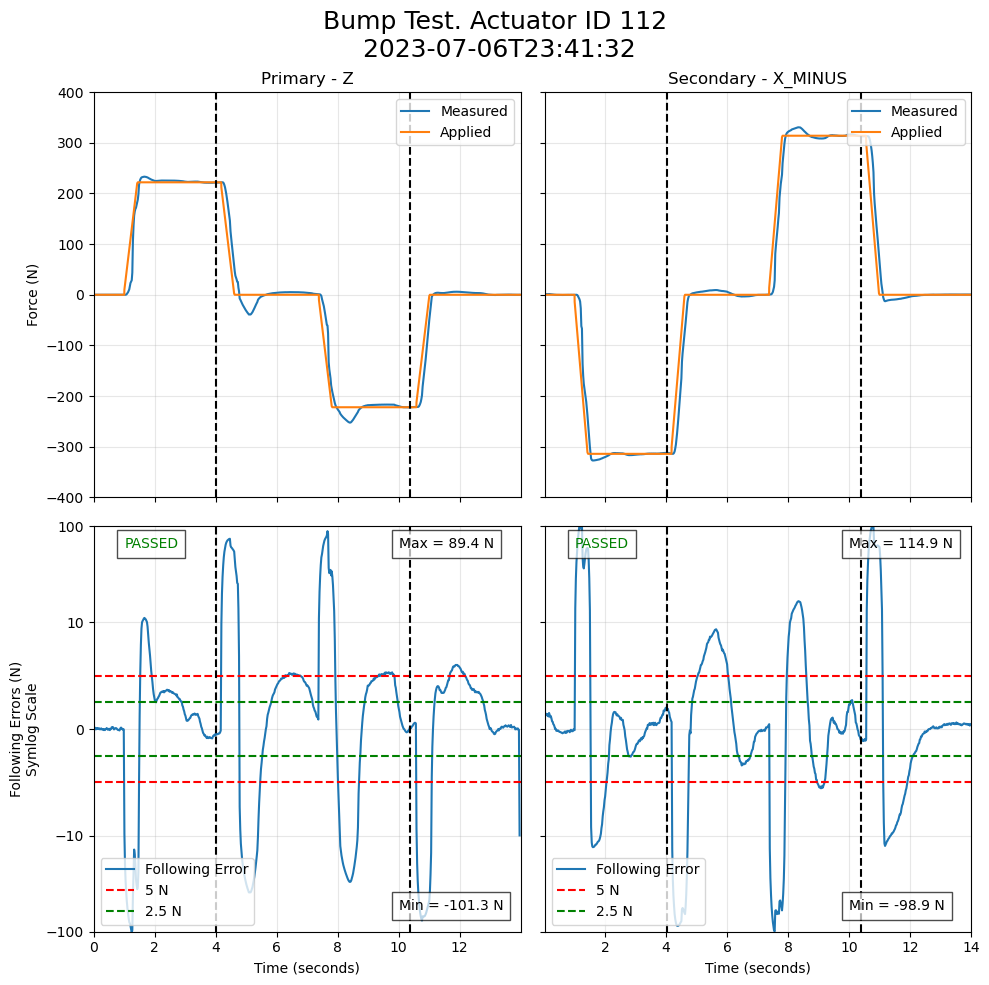

In [90]:
client = EfdClient('usdf_efd')
bumps = await client.select_time_series("lsst.sal.MTM1M3.logevent_forceActuatorBumpTestStatus", "*",\
                                        Time(start, scale='utc'), Time(end, scale='utc'))
# The actuator id runs from 101 to 443, as described in
# Section 2 of https://sitcomtn-083.lsst.io/
id = 112
fig = plt.figure(figsize=(10,10))
await plot_bump_test_following_errors(fig, bumps, id)
plt.savefig(str(data_dir / f"Bump_Test_Following_Errors_{id}.png"))


# Now run the whole bump test

In [ ]:
timestamp = bumps.index[0].isoformat().split('.')[0].replace('-','').replace(':','')
pdf = PdfPages(str(data_dir / f"Bump_Test_Following_Errors_{timestamp}.pdf"))
fig = plt.figure(figsize=(10,10))
for index in range(len(FATable)):
    try:
        id = FATable[index].actuator_id
        fig = await plot_bump_test_following_errors(fig, bumps, id)
        pdf.savefig(fig)  # saves the current figure into a pdf page
        print(f"Plot for actuator {id} succeeded!")
        plt.clf()
    except Exception as e:
        print(f"Plot for actuator {id} failed!")
        print(e)
        continue
pdf.close()
